In [ ]:
# ============================
# Full pipeline: Preprocess -> Train (Hybrid EfficientNetB0 + MobileNetV2) -> Evaluate
# - Colab-ready (mounts Drive if available)
# - Preprocessing: clean, normalize to .jpg, resize to 224x224, reproducible 80/20 split
# - Training: hybrid EfficientNetB0 + MobileNetV2, Stage1 frozen (80 epochs) + Stage2 fine-tune (20 epochs) = 100 epochs
# - Per-epoch metrics: accuracy, precision (macro), sensitivity/recall (macro), specificity (macro) printed for train & val
# - Saves best model by val_accuracy and final model
#
# Paste and run the entire script in order in Colab / Jupyter (cells are marked).
# ============================

# ----------------------------
# Cell A: Install deps (Colab only, safe if already installed)
# ----------------------------
# Uncomment if running in Colab and sklearn missing:
# !pip install -q scikit-learn

# ----------------------------
# Cell 1: Preprocessing (safe version)
# ----------------------------
# SETTINGS
dataset_dir = "/content/drive/MyDrive/CapStoneProjectDataSets/Sugarcane"
RANDOM_SEED = 42
TRAIN_RATIO = 0.8
TARGET_SIZE = (224, 224)  # (width, height)
ALLOWED_EXTS = {".jpg", ".jpeg", ".png"}

# IMPORTS
import os, random, shutil
from pathlib import Path
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# (Optional) Mount Drive if running in Colab
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)
except Exception:
    pass

src = Path(dataset_dir)
if not src.exists():
    raise FileNotFoundError(f"Dataset not found: {dataset_dir}")

# Find class folders (top-level directories only)
class_dirs = [p for p in src.iterdir() if p.is_dir() and not p.name.startswith(".")]
if not class_dirs:
    raise RuntimeError("No class subfolders found. Expecting folders like 'Healthy', 'Bacterial Blight', 'Red Rot' in dataset_dir")

print("Detected classes:", [d.name for d in class_dirs])

# Helpers
def safe_files(p: Path):
    return [x for x in p.iterdir() if x.is_file() and not x.name.startswith(".")]

def is_image_ok(p: Path):
    try:
        with Image.open(p) as im:
            im.verify()
        with Image.open(p) as im:
            w,h = im.size
        return w>0 and h>0
    except Exception:
        return False

def save_resized_jpg(src_path: Path, dst_dir: Path, size=TARGET_SIZE):
    dst_dir.mkdir(parents=True, exist_ok=True)
    base = src_path.stem
    candidate = dst_dir / f"{base}.jpg"
    suffix = 1
    while candidate.exists():
        candidate = dst_dir / f"{base}_{suffix}.jpg"
        suffix += 1
    with Image.open(src_path) as im:
        im = im.convert("RGB")
        im = im.resize(size, Image.BICUBIC)
        im.save(candidate, format="JPEG", quality=92)
    return candidate

# Move corrupt/unsupported files to review folder
corrupt_dir = src / "_CORRUPT_OR_INVALID"
corrupt_dir.mkdir(exist_ok=True)
moved_corrupt = 0

for c in class_dirs:
    for f in safe_files(c):
        if f.suffix.lower() not in ALLOWED_EXTS or not is_image_ok(f):
            try:
                shutil.move(str(f), str(corrupt_dir / f.name))
                moved_corrupt += 1
            except Exception:
                pass
print(f"Moved {moved_corrupt} corrupt/unsupported files (if any) to {corrupt_dir}")

# Prepare destination split folders
dst_base = src.with_name(src.name + "_split")
train_dir = dst_base / "train"
test_dir  = dst_base / "test"

if not dst_base.exists():
    dst_base.mkdir(parents=True, exist_ok=True)

random.seed(RANDOM_SEED)

for class_dir in class_dirs:
    imgs = [p for p in safe_files(class_dir) if p.suffix.lower() in ALLOWED_EXTS and is_image_ok(p)]
    imgs.sort()            # deterministic base order
    random.shuffle(imgs)
    n_train = int(len(imgs) * TRAIN_RATIO)
    train_list = imgs[:n_train]
    test_list  = imgs[n_train:]
    for s in train_list:
        save_resized_jpg(s, train_dir / class_dir.name)
    for s in test_list:
        save_resized_jpg(s, test_dir / class_dir.name)

print("Preprocessing complete.")
print("Train directory:", train_dir)
print("Test directory :", test_dir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Detected classes: ['Healthy', 'Red Rot', 'Bacterial Blight', '_CORRUPT_OR_INVALID']
Moved 0 corrupt/unsupported files (if any) to /content/drive/MyDrive/CapStoneProjectDataSets/Sugarcane/_CORRUPT_OR_INVALID
Preprocessing complete.
Train directory: /content/drive/MyDrive/CapStoneProjectDataSets/Sugarcane_split/train
Test directory : /content/drive/MyDrive/CapStoneProjectDataSets/Sugarcane_split/test


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 467 images belonging to 3 classes.
Found 100 images belonging to 3 classes.
Classes detected: {'Bacterial Blight': 0, 'Healthy': 1, 'Red Rot': 2}


/tmp/ipython-input-3787382665.py:90: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet = MobileNetV2(include_top=False, weights='imagenet', input_tensor=input_tensor)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_6         │ (None, 224, 224,  │          0 │ input_layer_3[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_3     │ (None, 224, 224,  │          7 │ rescaling_6[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_7         │ (None, 224, 224,  │          0 │ normalization_3[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_7[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 7,750,886 (29.57 MB)

 Trainable params: 1,443,331 (5.51 MB)

 Non-trainable params: 6,307,555 (24.06 MB)

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 119s 7s/step - accuracy: 0.3358 - loss: 1.2946 - val_accuracy: 0.5500 - val_loss: 0.9002 - learning_rate: 1.0000e-04
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 95s 6s/step - accuracy: 0.4851 - loss: 1.1247 - val_accuracy: 0.7300 - val_loss: 0.7501 - learning_rate: 1.0000e-04
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 87s 6s/step - accuracy: 0.5373 - loss: 0.9784 - val_accuracy: 0.6300 - val_loss: 0.7579 - learning_rate: 1.0000e-04
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 97s 7s/step - accuracy: 0.6284 - loss: 0.8397 - val_accuracy: 0.7400 - val_loss: 0.6495 - learning_rate: 1.0000e-04
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 88s 6s/step - accuracy: 0.6459 - loss: 0.7853 - val_accuracy: 0.7600 - val_loss: 0.6439 - learning_rate: 1.0000e-04
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 141s 6s/step - accuracy: 0.7064 - loss: 0.6745 - val_accuracy: 0.7300 - val_loss: 0.5932 - learning_rate: 1.0000e-04
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 149s 6s/step - accuracy: 0.6949 - lo

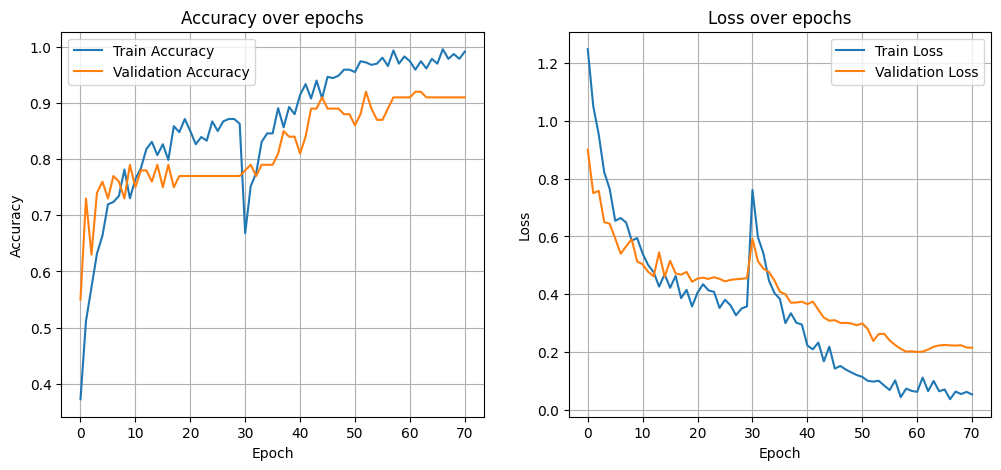

In [ ]:
# ================================
# Hybrid EfficientNetB0 + MobileNetV2 (Optimized, 100 Epochs, .keras)
# ================================

# 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2. Imports
import os, random
from pathlib import Path
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0, MobileNetV2
from tensorflow.keras.applications.efficientnet import preprocess_input as effnet_preprocess
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Concatenate, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score

# 3. Paths & Settings
dataset_dir = "/content/drive/MyDrive/CapStoneProjectDataSets/Sugarcane"
split_dir   = "/content/drive/MyDrive/CapStoneProjectDataSets/Sugarcane_split"
train_dir   = f"{split_dir}/train"
val_dir     = f"{split_dir}/test"

IMG_SIZE    = (224, 224)
BATCH_SIZE  = 32
EPOCHS_STAGE1 = 50
EPOCHS_STAGE2 = 50
LR_STAGE1   = 1e-4
LR_STAGE2   = 5e-5

best_model_path  = "/content/best_hybrid_model_ft.keras"
final_model_path = "/content/hybrid_model_100epochs_ft.keras"

# Delete old models if they exist
for f in [best_model_path, final_model_path]:
    if os.path.exists(f):
        os.remove(f)
        print(f"Deleted old model: {f}")

# 4. Data Generators (Augmented)
train_datagen = ImageDataGenerator(
    preprocessing_function=effnet_preprocess,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.25,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.7,1.3],
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(preprocessing_function=effnet_preprocess)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

num_classes = len(train_generator.class_indices)
print("Classes detected:", train_generator.class_indices)

# 5. Build Hybrid Model
input_tensor = Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

# EfficientNet branch
effnet = EfficientNetB0(include_top=False, weights='imagenet', input_tensor=input_tensor)
for layer in effnet.layers: layer.trainable = False
effnet_feat = GlobalAveragePooling2D()(effnet.output)

# MobileNet branch
mobilenet = MobileNetV2(include_top=False, weights='imagenet', input_tensor=input_tensor)
for layer in mobilenet.layers: layer.trainable = False
mobilenet_feat = GlobalAveragePooling2D()(mobilenet.output)

# Combine features
combined = Concatenate()([effnet_feat, mobilenet_feat])
x = Dense(512, activation='relu')(combined)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=input_tensor, outputs=output)
model.summary()

# 6. Callbacks (Silent)
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        best_model_path, save_best_only=True, monitor='val_accuracy', mode='max', verbose=0
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=3, verbose=0
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=10, restore_best_weights=True, verbose=0
    )
]

# 7. Stage 1: Train top layers only
model.compile(optimizer=Adam(learning_rate=LR_STAGE1),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_stage1 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS_STAGE1,
    verbose=1,
    callbacks=callbacks
)

# 8. Stage 2: Fine-tune last 50 layers
for layer in effnet.layers[-50:]: layer.trainable = True
for layer in mobilenet.layers[-50:]: layer.trainable = True

model.compile(optimizer=Adam(learning_rate=LR_STAGE2),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_stage2 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS_STAGE2,
    verbose=1,
    callbacks=callbacks
)

# 9. Evaluation
val_generator.reset()
y_true = val_generator.classes
preds = model.predict(val_generator, verbose=0)
y_pred = np.argmax(preds, axis=1)

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='macro', zero_division=0)
recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
cm = confusion_matrix(y_true, y_pred)

spec_list = []
total = np.sum(cm)
for i in range(num_classes):
    TP = cm[i,i]
    FP = np.sum(cm[:,i])-TP
    FN = np.sum(cm[i,:])-TP
    TN = total-TP-FP-FN
    spec_list.append(TN/(TN+FP+1e-7))
spec = np.mean(spec_list)

print("\n=== FINAL METRICS ON TEST SET ===")
print(f"Accuracy: {acc*100:.2f}%")
print(f"Precision: {prec*100:.2f}%")
print(f"Sensitivity (Recall): {recall*100:.2f}%")
print(f"Specificity: {spec*100:.2f}%")

# 10. Save final model
model.save(final_model_path)
print("Final model saved to:", final_model_path)
print("Best model saved to:", best_model_path)

# 11. Plot training curves
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_stage1.history['accuracy'] + history_stage2.history['accuracy'], label='Train Accuracy')
plt.plot(history_stage1.history['val_accuracy'] + history_stage2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(history_stage1.history['loss'] + history_stage2.history['loss'], label='Train Loss')
plt.plot(history_stage1.history['val_loss'] + history_stage2.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded model: /content/hybrid_model_100epochs_ft.keras
Found 100 images belonging to 3 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/4 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 5s/step

=== TEST SET METRICS ===
Samples: 100
Accuracy:  91.00%
Precision: 89.59% (macro)
Recall:    90.00% (macro, sensitivity)
Specificity: 95.56% (macro)

Classification report (per class):
                  precision    recall  f1-score   support

Bacterial Blight       0.81      0.85      0.83        20
         Healthy       1.00      0.95      0.97        40
         Red Rot       0.88      0.90      0.89        40

        accuracy                           0.91       100
       macro avg       0.90      0.90      0.90       100
    weighted avg       0.91      0.91      0.91       100


Confusion matrix:
[[17  0  3]
 [ 0 38  2]
 [ 4  0 36]]

Saved test predictions to: /content/test_predictions.csv


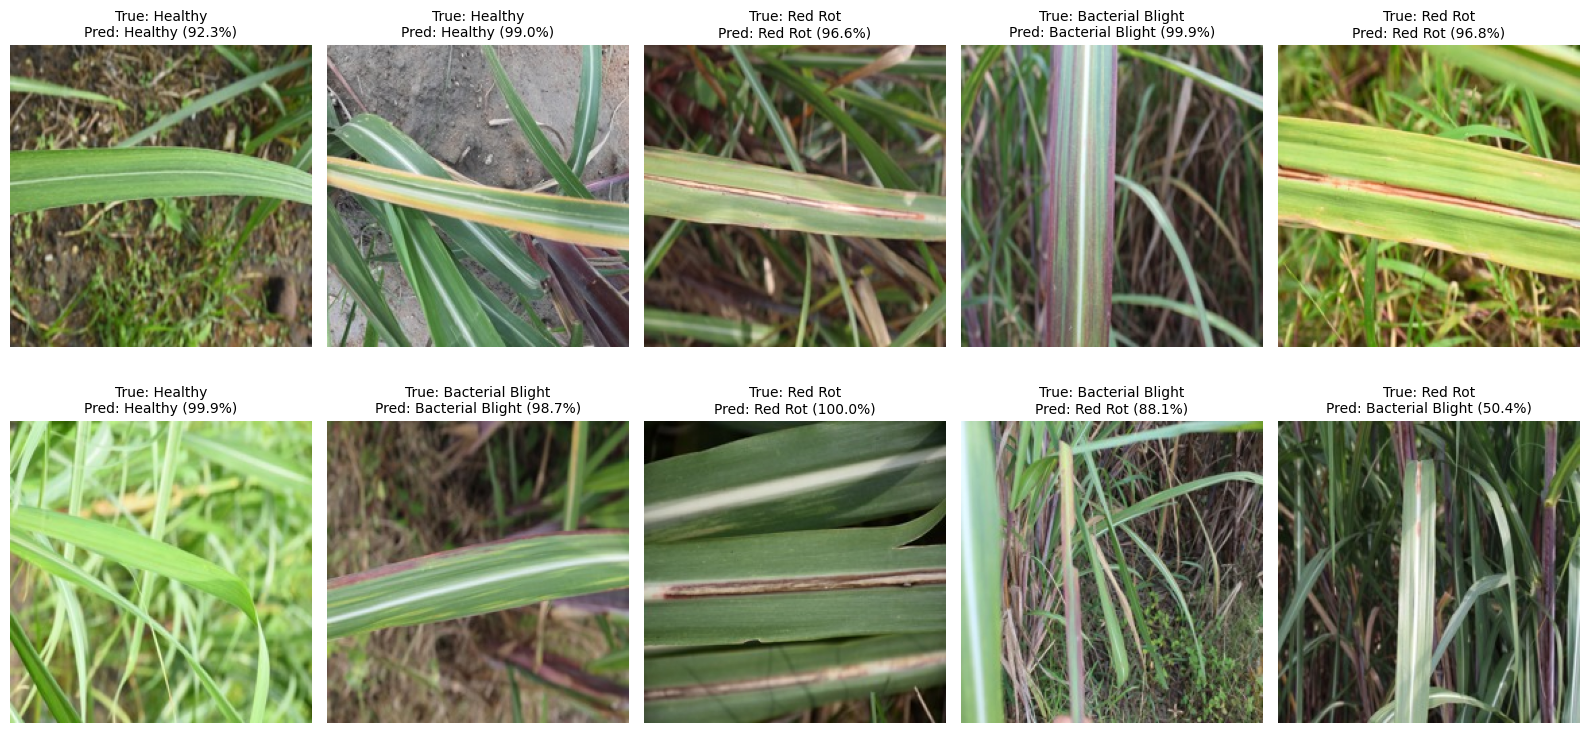


Sample top-k predictions for the first 5 test images:
S_BLB (1).jpg: top-3 -> ['Bacterial Blight', 'Red Rot', 'Healthy'] (confidences: [0.982 0.016 0.002])
S_BLB (100).jpg: top-3 -> ['Bacterial Blight', 'Healthy', 'Red Rot'] (confidences: [0.987 0.012 0.001])
S_BLB (15).jpg: top-3 -> ['Bacterial Blight', 'Red Rot', 'Healthy'] (confidences: [0.8   0.187 0.013])
S_BLB (16).jpg: top-3 -> ['Bacterial Blight', 'Red Rot', 'Healthy'] (confidences: [0.761 0.234 0.006])
S_BLB (17).jpg: top-3 -> ['Bacterial Blight', 'Red Rot', 'Healthy'] (confidences: [0.995 0.005 0.   ])


In [ ]:
# ==============================
# Testing / Inference script
# ==============================

# 0. (Optional) Mount Drive if necessary
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

# 1. Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input as effnet_preprocess
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report

# 2. Paths & settings — adjust if needed
split_dir   = "/content/drive/MyDrive/CapStoneProjectDataSets/Sugarcane_split"
test_dir    = os.path.join(split_dir, "test")    # your test folder
final_model_path = "/content/hybrid_model_100epochs_ft.keras"   # path to your saved final model
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# 3. Load model
if not os.path.exists(final_model_path):
    raise FileNotFoundError(f"Model file not found: {final_model_path}")
model = tf.keras.models.load_model(final_model_path)
print("Loaded model:", final_model_path)

# 4. Test data generator (same preprocessing used in training)
test_datagen = ImageDataGenerator(preprocessing_function=effnet_preprocess)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# 5. Predict on entire test set
test_steps = int(np.ceil(test_generator.samples / BATCH_SIZE))
preds_proba = model.predict(test_generator, steps=test_steps, verbose=1)  # shape (n_samples, n_classes)
y_prob = preds_proba
y_pred = np.argmax(preds_proba, axis=1)
y_true = test_generator.classes
class_indices = test_generator.class_indices
# invert class_indices -> label name mapping
inv_map = {v: k for k, v in class_indices.items()}

# 6. Compute metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
recall = recall_score(y_true, y_pred, average='macro', zero_division=0)

# Specificity (per-class then macro)
cm = confusion_matrix(y_true, y_pred)
spec_list = []
total = np.sum(cm)
for i in range(len(cm)):
    TP = cm[i, i]
    FP = np.sum(cm[:, i]) - TP
    FN = np.sum(cm[i, :]) - TP
    TN = total - TP - FP - FN
    spec = TN / (TN + FP + 1e-7)
    spec_list.append(spec)
specificity_macro = float(np.mean(spec_list))

print("\n=== TEST SET METRICS ===")
print(f"Samples: {len(y_true)}")
print(f"Accuracy:  {accuracy*100:.2f}%")
print(f"Precision: {precision*100:.2f}% (macro)")
print(f"Recall:    {recall*100:.2f}% (macro, sensitivity)")
print(f"Specificity: {specificity_macro*100:.2f}% (macro)")

# 7. Classification report & confusion matrix (per-class)
print("\nClassification report (per class):")
print(classification_report(y_true, y_pred, target_names=[inv_map[i] for i in range(len(inv_map))], zero_division=0))

print("\nConfusion matrix:")
print(cm)

# 8. Save predictions to CSV
filepaths = np.array(test_generator.filepaths)
pred_labels = [inv_map[i] for i in y_pred]
true_labels = [inv_map[i] for i in y_true]
top_confidences = np.max(y_prob, axis=1)

out_df = pd.DataFrame({
    "filepath": filepaths,
    "true_label": true_labels,
    "pred_label": pred_labels,
    "confidence": top_confidences
})
csv_path = "/content/test_predictions.csv"
out_df.to_csv(csv_path, index=False)
print(f"\nSaved test predictions to: {csv_path}")

# 9. Show some example predictions (n_samples random)
import random
n_samples = 10
idxs = list(range(len(filepaths)))
random.seed(42)
random.shuffle(idxs)
show_idxs = idxs[:n_samples]

plt.figure(figsize=(16, 8))
for i, idx in enumerate(show_idxs):
    img_path = filepaths[idx]
    img = Image.open(img_path).convert("RGB").resize(IMG_SIZE)
    plt.subplot(2, (n_samples+1)//2, i+1)
    plt.imshow(img)
    plt.axis('off')
    tl = true_labels[idx]
    pl = pred_labels[idx]
    conf = top_confidences[idx]
    title = f"True: {tl}\nPred: {pl} ({conf*100:.1f}%)"
    plt.title(title, fontsize=10)
plt.tight_layout()
plt.show()

# 10. (Optional) Top-k for each sample (k=3)
k = min(3, preds_proba.shape[1])
topk = np.argsort(preds_proba, axis=1)[:, ::-1][:, :k]
topk_labels = [[inv_map[c] for c in row] for row in topk]
print("\nSample top-k predictions for the first 5 test images:")
for i in range(min(5, len(filepaths))):
    print(f"{Path(filepaths[i]).name}: top-{k} -> {topk_labels[i]} (confidences: {np.round(np.sort(preds_proba[i])[-k:][::-1],3)})")

# Done
